In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(21601,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_GPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((20732,), (20732,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Set parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start+0.75*Tobs)/DAY, t_end/DAY] # ensure at least 75% Tobs data before merger 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.9       ,  0.9       ],
       [-0.9       ,  0.9       ],
       [13.75      , 15.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

## Set noise model

In [6]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 20732), (20732, 3, 3))

## Data generation 

In [7]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 3078146.3223326076
mass_ratio : 0.28161675371226635
spin_1z : 0.5413297487089422
spin_2z : -0.24846476519093108
coalescence_time : 14.10781902418914
coalescence_phase : 0.30598750370997085
luminosity_distance : 17535.36512697265
inclination : 1.2188134217200073
longitude : 1.1059936041986338
latitude : -0.2511632373825511
psi : 3.0735219133127436
optimal SNR: 3309.5413934735557


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

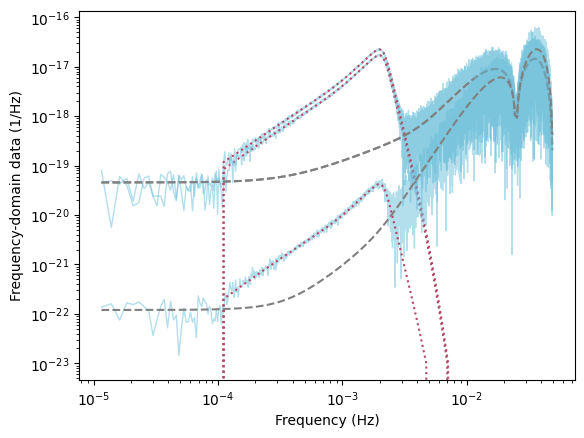

In [8]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [9]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 20732
min and max frequencies: 1.1574074074074073e-05 0.049
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}
number of freuqncies: 20732
min and max frequencies: 1.1574074074074073e-05 0.049
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### compare $\mathcal{F}$-stat and likelihood around truths

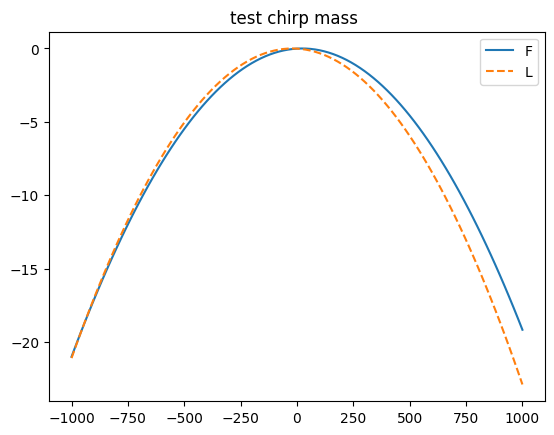

In [10]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test chirp mass ")
plt.legend()

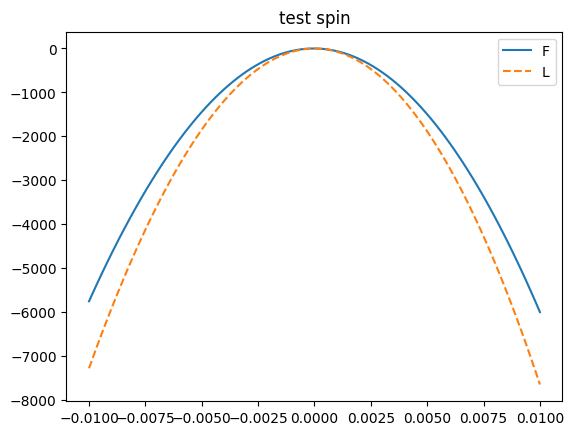

In [11]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.01, 0.01, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test spin")
plt.legend()

max F point = 14.107819224189141
max L point = 14.10781942418914
deviation = 1.999999987845058e-07


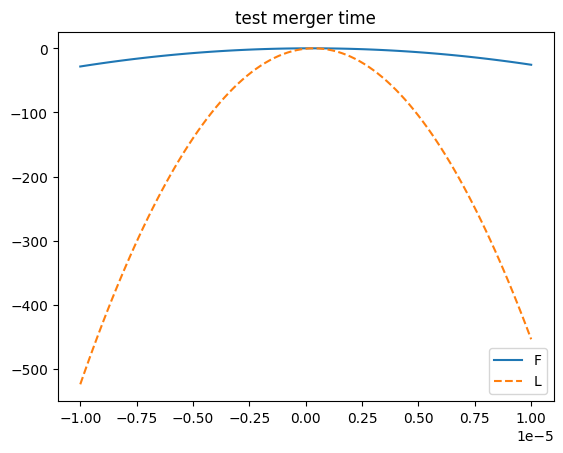

In [12]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-1e-5, 1e-5, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test merger time")

tc_best_F = test_int_params["coalescence_time"][np.argmax(test_F)]
tc_best_L = test_params["coalescence_time"][np.argmax(test_L)]
print("max F point =", tc_best_F)
print("max L point =", tc_best_L)
print("deviation =", tc_best_L - tc_best_F)
plt.legend()

max F point = 1.1059936041986338
max L point = 1.1059936041986338
deviation = 0.0


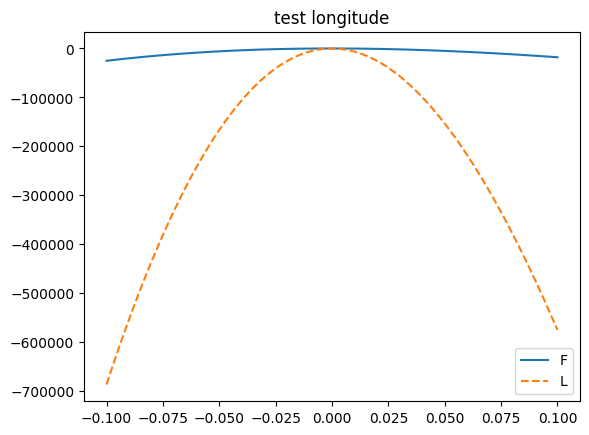

In [13]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["longitude"] = mbhb_parameters["longitude"] + np.linspace(-1e-1, 1e-1, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["longitude"] = test_int_params["longitude"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["longitude"] - mbhb_parameters["longitude"], test_F - np.max(test_F), label="F")
plt.plot(test_int_params["longitude"] - mbhb_parameters["longitude"], test_L - np.max(test_L), linestyle="--", label="L")
plt.title("test longitude")

tc_best_F = test_int_params["longitude"][np.argmax(test_F)]
tc_best_L = test_params["longitude"][np.argmax(test_L)]
print("max F point =", tc_best_F)
print("max L point =", tc_best_L)
print("deviation =", tc_best_L - tc_best_F)
plt.legend()

## Optimize from priors

In [ ]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-7,
    atol=1e-9,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    vectorized=True,
)
print(DE_result)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


### reconstruct parameters and waveforms 

In [ ]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

searched_wf = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)[:, 0, :]

# searched_wf = FDTDI_GPU.Response(
#     searched_params, 
#     data_frequencies_GPU, 
#     **response_kwargs_GPU
# )

print("parameter name | difference")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]))

parameter name | difference
chirp_mass 641.6051711218897
mass_ratio 0.005593648830484854
spin_1z 0.04058876781876741
spin_2z 0.08780761808616833
coalescence_time 0.001643705443077792
longitude 2.737067730019144
latitude 0.21805651019784494
luminosity_distance 46900.7765065271
inclination 0.47621333175862146
psi 0.9301333827317787
coalescence_phase 2.6420657117470525


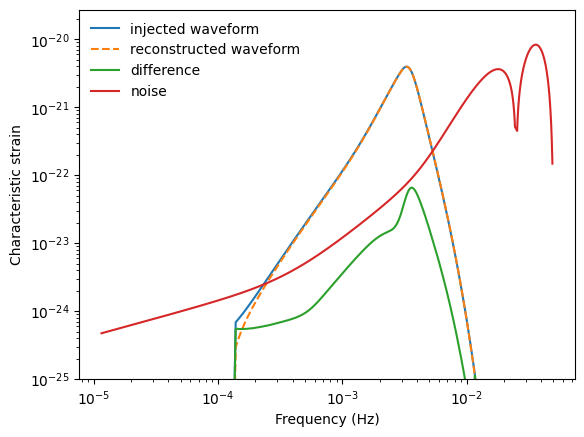

In [ ]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-", label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [ ]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 3668.4813924411346,
 'mass_ratio': 0.009609919796269005,
 'spin_1z': 0.06675142360029346,
 'spin_2z': 0.16264589053626818,
 'coalescence_time': 0.00028477017281805,
 'coalescence_phase': 0.01959046288606936,
 'luminosity_distance': 7254.439075500325,
 'inclination': 0.0038494420725218945,
 'longitude': 0.050611414570704984,
 'latitude': 0.0737537323199253,
 'psi': 0.01901114510294177}

In [ ]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 641.6051711218897 3668.4813924411346 0.17489666771757656
mass_ratio 0.005593648830484854 0.009609919796269005 0.5820702928922004
spin_1z 0.04058876781876741 0.06675142360029346 0.6080584597238309
spin_2z 0.08780761808616833 0.16264589053626818 0.5398698841800016
coalescence_time 0.001643705443077792 0.00028477017281805 5.772042158811397
longitude 2.737067730019144 0.050611414570704984 54.08004801358427
latitude 0.21805651019784494 0.0737537323199253 2.956548819142741
luminosity_distance 46900.7765065271 7254.439075500325 6.465114120941521
inclination 0.47621333175862146 0.0038494420725218945 123.70970202615327
psi 0.9301333827317787 0.01901114510294177 48.925689520293574
coalescence_phase 2.6420657117470525 0.01959046288606936 134.86489457203214


## The 1st heterodyned search 

In [ ]:
Like.prepare_het_log_like(
    # base_parameters=ParamDict2ParamArr(searched_params), 
    base_waveform=searched_wf
    ) 

TypeError: Unsupported type <class 'numpy.ndarray'>

(1e-22, 2.7214942345141023e-16)

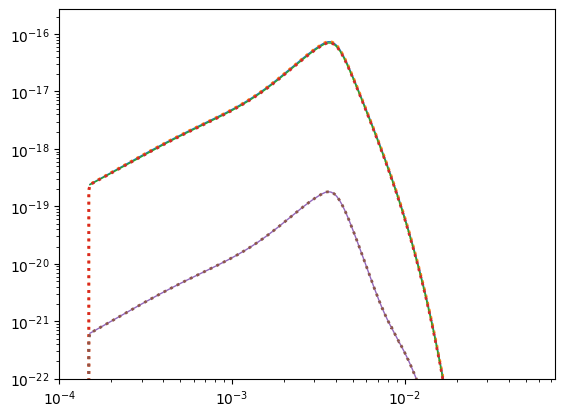

In [ ]:
for i in range(3):
    plt.loglog(Like.het_frequency.get(), np.abs(Like.het_h0[i].get()), linewidth=1)
    plt.loglog(data_frequencies, np.abs(searched_wf[i].get()), linestyle=":", linewidth=2)
plt.xlim(1e-4,)
plt.ylim(1e-22,)

(1e-20, 3.8164381596259685e-16)

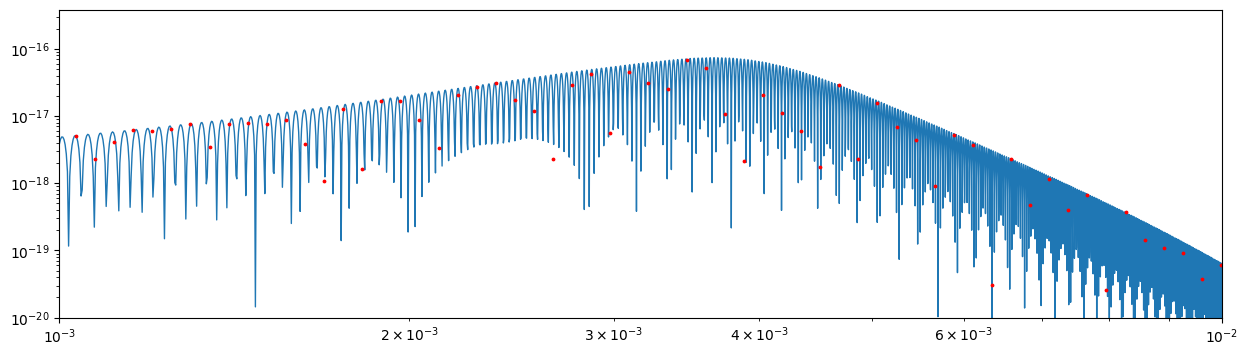

In [ ]:
plt.figure(figsize=(15,4))
for i in range(1):
    plt.scatter(Like.het_frequency.get(), np.abs(np.real(Like.het_h0[i].get())), s=3, color="red", zorder=2)
    plt.plot(data_frequencies, np.abs(np.real(searched_wf[i].get())), linestyle="-", linewidth=1, alpha=1, zorder=1)
plt.xlim(0.001, 0.01)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-20,)

(1e-20, 4.4064732273812936e-16)

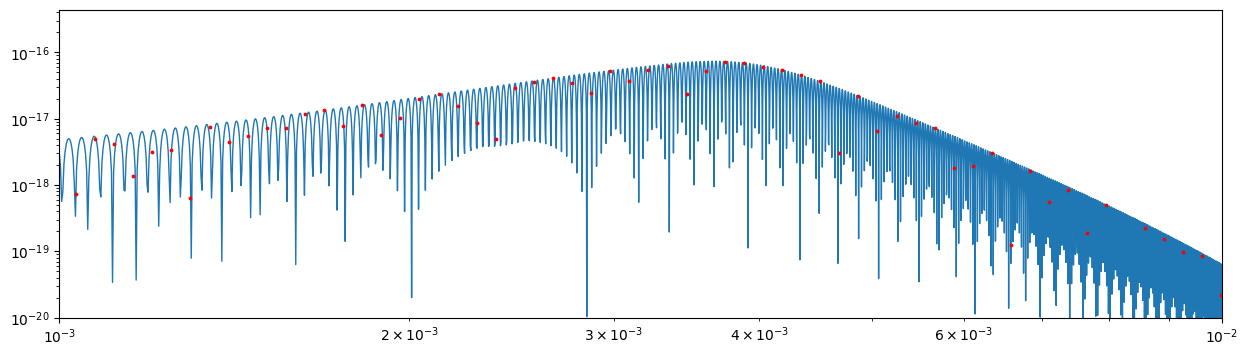

In [ ]:
plt.figure(figsize=(15,4))
for i in range(1):
    plt.scatter(Like.het_frequency.get(), np.abs(np.imag(Like.het_h0[i].get())), s=3, color="red", zorder=2)
    plt.plot(data_frequencies, np.abs(np.imag(searched_wf[i].get())), linestyle="-", linewidth=1, alpha=1, zorder=1)
plt.xlim(0.001, 0.01)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-20,)

In [ ]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [ ]:
truths = np.array(ParamDict2ParamArr(searched_params)) # actually the searched values 
ground_truths = np.array(ParamDict2ParamArr(mbhb_parameters))
labels = np.array(list(mbhb_parameters.keys()))
fim_range = []
for par in labels:
    if par in ["chirp_mass", "luminosity_distance"]:
        ran = FIM.param_errors[par] / searched_params[par] / np.log(10.) # lg value 
    else:
        ran = FIM.param_errors[par] 
    fim_range.append(ran)
fim_range = np.array(fim_range) * 10. # ~10 sigmas, NOTE that not all of the priors are decided by fisher 

for idx, par in enumerate(labels):
    print(par, truths[idx], fim_range[idx])

chirp_mass 6.21243940727639 0.0004557289703625706
mass_ratio 0.6102958167715679 0.016671964401989824
spin_1z -0.6141884724840101 0.13180931438574855
spin_2z -0.825279388836741 0.23093392043200173
coalescence_time 14.79763474969457 0.00024224621844462523
coalescence_phase 5.6886062743909225 0.16066006568594865
luminosity_distance 4.036160457223637 0.024362213679329264
inclination -0.7262145126210542 0.04598639754397302
longitude 0.8198141656068548 0.06402514546521697
latitude -0.3519432635882035 0.11863588929615132
psi 0.2963325732490417 0.19206125032515103


In [ ]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 1000 # number of random walkers, more walkers can be used since heterodyned likelihood requires much less vRAM, 400 is a quite large number for this task 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set a narrower prior for the instrinsic parameters, since heterodyned likelihood must be based on an initial estimation 
lim_lgMc = [truths[0] - fim_range[0], truths[0] + fim_range[0]]
lim_q = [max(0.1, truths[1] - fim_range[1]), min(1., truths[1] + fim_range[1])]
lim_chiz1 = [max(-0.9, truths[2] - fim_range[2]), min(0.9, truths[2] + fim_range[2])]
lim_chiz2 = [max(-0.9, truths[3] - fim_range[3]), min(0.9, truths[3] + fim_range[3])]
# lim_tc = [truths[4] - 0.01 * searched_params["chirp_mass"] / 1e6, truths[4] + 0.01 * searched_params["chirp_mass"] / 1e6] # empirical 
lim_tc = [truths[4] - 0.01, truths[4] + 0.01] # empirical 
lim_phic = [0, TWOPI]
lim_lgD = [max(lgdl_prior[0], truths[6]-fim_range[6]), min(lgdl_prior[1], truths[6]+fim_range[6])]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
# start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_lims = lims.copy()
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 6.21198368,  6.21289514],
        [ 0.59362385,  0.62696778],
        [-0.74599779, -0.48237916],
        [-0.9       , -0.59434547],
        [14.78763475, 14.80763475],
        [ 0.        ,  6.28318531],
        [ 4.01179824,  4.06052267],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]),
 array([[ 6.21198368,  6.21289514],
        [ 0.59362385,  0.62696778],
        [-0.74599779, -0.48237916],
        [-0.9       , -0.59434547],
        [14.78763475, 14.80763475],
        [ 0.        ,  6.28318531],
        [ 4.01179824,  4.06052267],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]))

In [ ]:
((lims.T - ground_truths)[0] < 0.).all(), ((lims.T - ground_truths)[1] > 0.).all()

(True, True)

In [ ]:
lims.T - ground_truths

array([[-5.15763715e-04, -1.64311134e-02, -1.34524221e-01,
        -7.11572129e-02, -2.85898046e-03, -2.56978917e+00,
        -2.05278747e-02, -1.72730082e+00, -5.65511296e+00,
        -1.37495680e+00, -5.00122994e-01],
       [ 3.95694226e-04,  1.69128154e-02,  1.29094408e-01,
         2.34497319e-01,  1.71410195e-02,  3.71339614e+00,
         2.81965526e-02,  2.72699184e-01,  6.28072343e-01,
         6.25043198e-01,  2.64146966e+00]])

In [ ]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    # return Like.full_log_like_vectorized(np.transpose(params))
    return Like.het_log_like_vectorized(np.transpose(params))

In [ ]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [ ]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 1000, 11)


  1%|▏         | 1399/100000 [23:17<26:40:20,  1.03it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_7758/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 337, in het_log_like_vectorized
    # 1) h_h term
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where(t < tmin * DAY)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.21254851,  0.61182738, -0.63125966, ...,  1.99256409,
        -0.02626913,  1.6097097 ],
       [ 6.21246466,  0.61185311, -0.61622104, ...,  2.13766296,
        -0.19999833,  1.60118975],
       [ 6.21254104,  0.61151584, -0.62508876, ...,  2.07563932,
        -0.12660179,  1.60662672],
       ...,
       [ 6.21246448,  0.61299589, -0.70977597, ...,  3.86559654,
        -0.92257788,  2.42596078],
       [ 6.21268262,  0.60988709, -0.57687089, ...,  4.99603584,
         0.09115549,  1.4216532 ],
       [ 6.21263865,  0.6188585 , -0.50347656, ...,  0.90706017,
         0.84335597,  0.30055048]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(150000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

 13%|█▎        | 19921/150000 [1:49:42<11:46:26,  3.07it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_20330/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 324, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where(t < tmin * DAY)
  File "/

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.06085751,  0.2541853 ,  0.36596539, ...,  3.15470111,
        -0.27247159,  0.68285522],
       [ 6.06065558,  0.25363127,  0.3678356 , ...,  3.15218458,
        -0.26238568,  0.48036772],
       [ 6.06036007,  0.25481495,  0.35583669, ...,  3.17614592,
        -0.24034097,  1.96595959],
       ...,
       [ 6.05906473,  0.26173246,  0.42527901, ...,  1.70045314,
         0.57883293,  1.40001287],
       [ 6.05912258,  0.24741675,  0.43833501, ...,  1.67216363,
         0.18573292,  3.06401209],
       [ 6.05935039,  0.25699743,  0.42237182, ...,  5.30854478,
        -0.0588558 ,  1.64454713]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

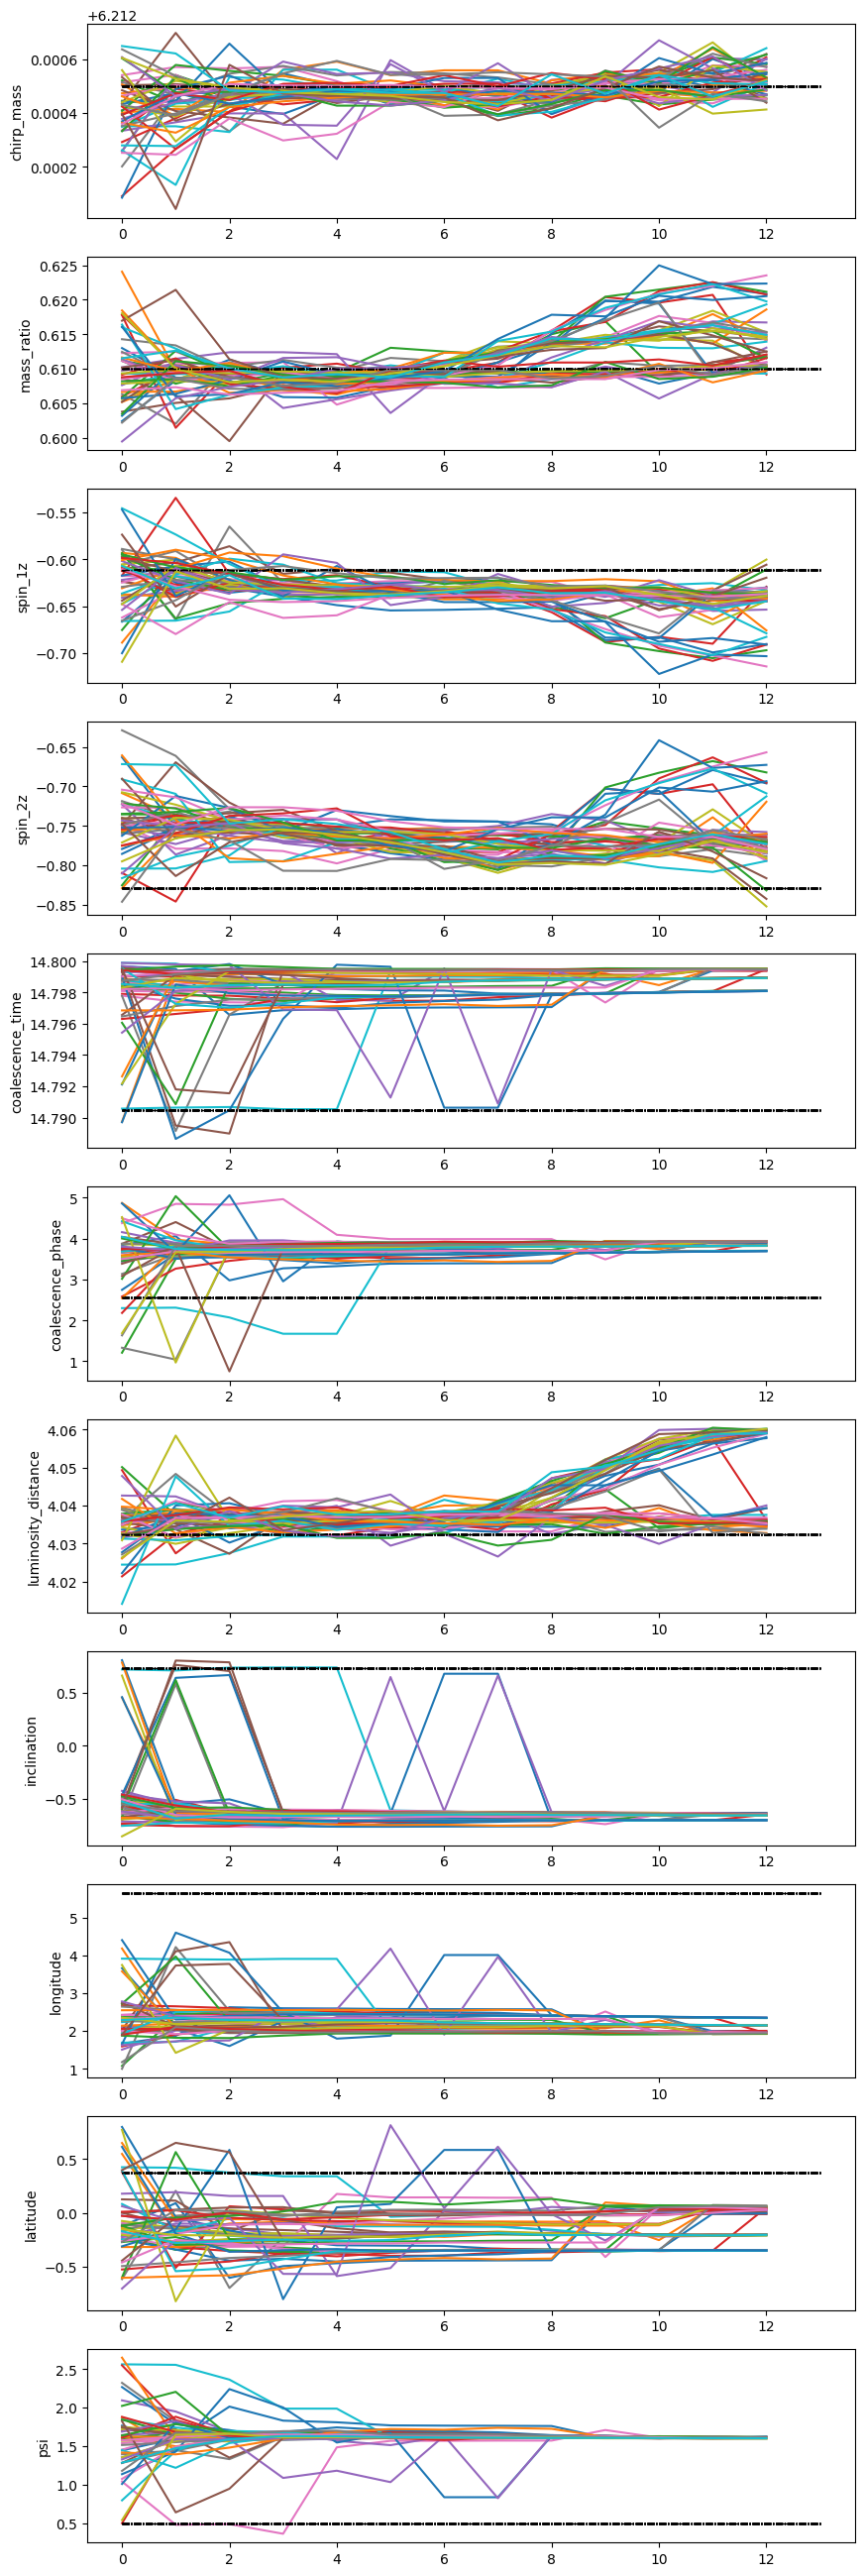

In [ ]:
thin = 1
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(50): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(ground_truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_het.jpg", dpi=360)

sample shape: (39600, 11)


<Figure size 640x480 with 0 Axes>

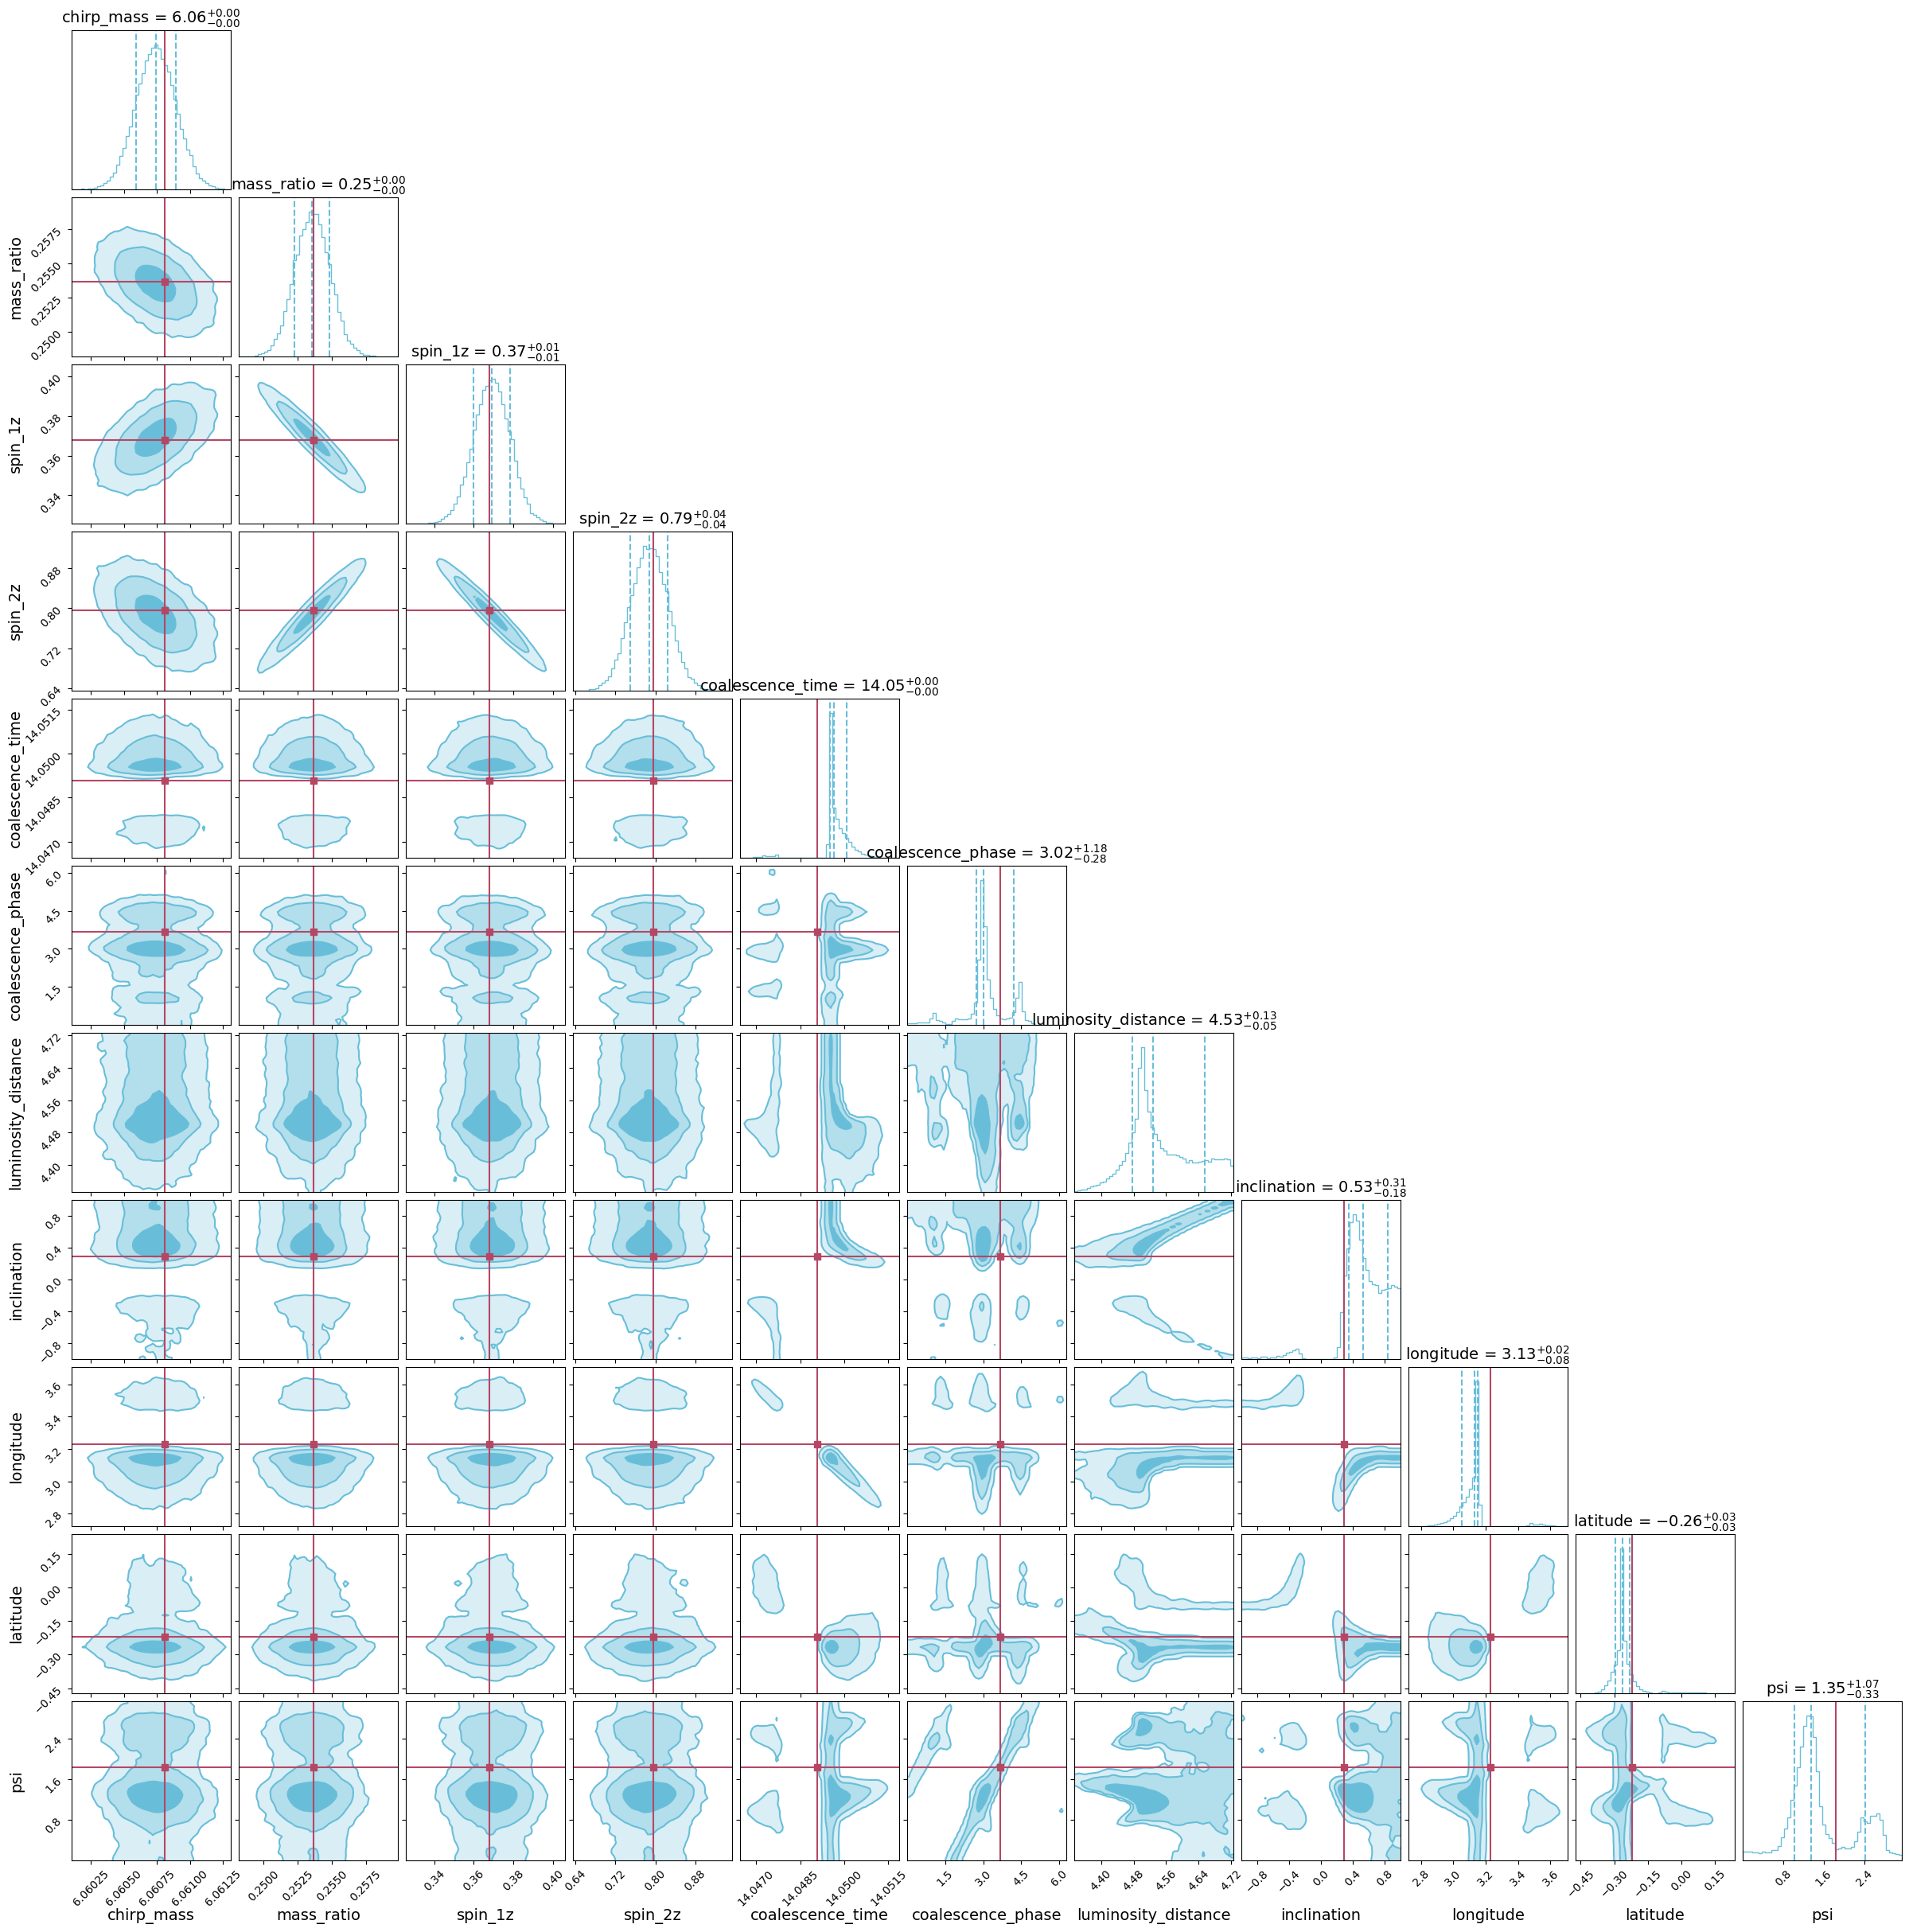

In [ ]:
burnin=200
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=ground_truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_het.jpg", dpi=360)
# np.save("chain_het.npy", samp)

In [ ]:
truths - ground_truths

array([-5.44836240e-06, -5.77726615e-05,  1.40369313e-03, -8.26486765e-03,
       -1.75234644e-03, -3.84181293e+00,  3.11768544e-01, -6.30611058e-01,
        3.09964724e-01,  2.50215666e-01, -2.54684751e+00])

In [ ]:
ground_truths

array([ 6.06081086,  0.25364638,  0.36789836,  0.7958377 , 14.04907261,
        3.66372009,  4.17163975,  0.28642366,  3.23109711, -0.21939293,
        1.83877349])